**ASSIGNMENT 1**

In [ ]:
import random
import jax.numpy as np
import numpy as onp
import os as os
import pylab as plt
import h5py # to read hdf5 files
import pandas as pd
from google.colab import drive
import jax
drive.mount('/content/drive')
import imageio
from skimage.transform import rescale, resize, downscale_local_mean
from tqdm.notebook import tqdm
import time
import scipy
#from jax.config import config; config.update("jax_enable_x64", True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Checking Data**

In [ ]:
path_csv  = "/content/drive/My Drive/DSA4212/Data/"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))
print(attribute.shape)

#let us list all the files in the image directory
path = "/content/drive/My Drive/DSA4212/Data/Celebrities"
all_img = os.listdir(path)
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

(202599, 41)
Number of images: 20000


**Basic Exploratory Data Analysis for Attributes**

In [ ]:
corr_data = pd.DataFrame()
corr_list = []
for feature in attribute.iloc[:,1:-1].columns:
  corr_list.append(attribute[feature].corr(attribute['Young']))
corr_data['Feature'] = attribute.iloc[:,1:-1].columns
corr_data['Correlation'] = corr_list
corr_data.sort_values(['Correlation']).head() #expand further to see the highest direct correlation

,Feature,Correlation
17,Gray_Hair,-0.374376
14,Double_Chin,-0.312818
13,Chubby,-0.300956
20,Male,-0.285530
7,Big_Nose,-0.284754


In [ ]:
young_data = attribute[attribute['Young']==1]
old_data = attribute[attribute['Young']==-1]

young_prop_data = pd.DataFrame()
for feature in young_data.iloc[:,1:-1].columns:
  temp = []
  temp.append(young_data[young_data[feature]==-1].shape[0]/young_data.shape[0])
  temp.append(young_data[young_data[feature]==1].shape[0]/young_data.shape[0])
  young_prop_data[feature] = temp

young_prop_data = young_prop_data.transpose().sort_values([1],ascending=False)

old_prop_data = pd.DataFrame()
for feature in old_data.iloc[:,1:-1].columns:
  temp = []
  temp.append(old_data[old_data[feature]==-1].shape[0]/old_data.shape[0])
  temp.append(old_data[old_data[feature]==1].shape[0]/old_data.shape[0])
  old_prop_data[feature] = temp

old_prop_data = old_prop_data.transpose().sort_values([1],ascending=False)

full_prop_data = young_prop_data.merge(old_prop_data.iloc[:,1], left_index=True, right_index=True).drop([0],axis=1)
full_prop_data.columns = ['Young','Old']
full_prop_data['Difference'] = abs(full_prop_data['Young']-full_prop_data['Old'])
full_prop_data = full_prop_data.sort_values(['Difference'],ascending=False)
full_prop_data.head()

,Young,Old,Difference
Attractive,0.617643,0.142662,0.474981
Male,0.346647,0.686960,0.340313
Wearing_Lipstick,0.538979,0.230350,0.308630
Heavy_Makeup,0.449352,0.156520,0.292833
Big_Nose,0.173035,0.465470,0.292435


**Initialising Data**

In [ ]:
#splitting training and validation set
train_n_img = 12000
val_n_img = 3000
test_n_img = 5000

train_img_array = onp.zeros((train_n_img, 51,34,3))
val_img_array = onp.zeros((val_n_img, 51,34,3))
test_img_array = onp.zeros((test_n_img, 51,34,3))

**Loading Data**

In [ ]:
for k in tqdm(range(train_n_img)):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = im[40:190, 40:140]
    im = resize(im,(51,34))
    #im = onp.mean(im, axis=2)
    im = im/255.
    train_img_array[k,:,:] = im
np.save('train_array', train_img_array)



In [ ]:
for p in tqdm(range(val_n_img)):
    im = imageio.imread(os.path.join(path, all_img[12000+p])).astype(float)
    im = im[40:190, 40:140]
    im = resize(im,(51,34))
    #im = onp.mean(im, axis=2)
    im = im/255.
    val_img_array[p,:,:] = im
np.save('val_array', val_img_array)



In [ ]:
for q in tqdm(range(test_n_img)):
    im = imageio.imread(os.path.join(path, all_img[15000+q])).astype(float)
    im = im[40:190, 40:140]
    im = resize(im,(51,34))
    #im = onp.mean(im, axis=2)
    im = im/255.
    test_img_array[q,:,:] = im
np.save('test_array', test_img_array)

In [ ]:
train_img_array = np.load('train_array.npy')
val_img_array = np.load('val_array.npy')
test_img_array = np.load('test_array.npy')

In [ ]:
train_y = onp.array(attribute[:12000]['Young'])
val_y = onp.array(attribute[12000:15000]['Young'])
test_y = onp.array(attribute[15000:]['Young'])
full_train_y = np.concatenate((train_y, val_y))

**Undersampling Data**

In [ ]:
attribute[:12000]['Young'].value_counts()

 1    9351
-1    2649
Name: Young, dtype: int64

In [ ]:
train_img_array_old = train_img_array[onp.where(train_y==-1)]
train_img_array_young = train_img_array[onp.where(train_y==1)]
idx = onp.random.randint(0, train_img_array_young.shape[0],size=train_img_array_old.shape[0])
train_img_array_temp = onp.append(train_img_array_young[idx],train_img_array_old, axis=0)
train_y = onp.append(np.array([1]*train_img_array_old.shape[0]),np.array([-1]*train_img_array_old.shape[0]), axis=0)

In [ ]:
attribute[:15000]['Young'].value_counts()

 1    11669
-1     3331
Name: Young, dtype: int64

In [ ]:
full_train_img_array = np.concatenate((train_img_array, val_img_array))
full_train_img_array_old = full_train_img_array[onp.where(full_train_y==-1)]
full_train_img_array_young = full_train_img_array[onp.where(full_train_y==1)]
idx = onp.random.randint(0, full_train_img_array_young.shape[0],size=full_train_img_array_old.shape[0])
full_train_img_array_temp = onp.append(full_train_img_array_young[idx],full_train_img_array_old, axis=0)
full_train_y = onp.append(np.array([1]*full_train_img_array_old.shape[0]),np.array([-1]*full_train_img_array_old.shape[0]), axis=0)

**Processed Data**

In [ ]:
data_train = train_img_array_temp.reshape(train_img_array_temp.shape[0], 51*34*3)
data_val = val_img_array.reshape(val_img_array.shape[0], 51*34*3)
data_test = test_img_array.reshape(test_img_array.shape[0], 51*34*3)
data_full_train = full_train_img_array_temp.reshape(full_train_img_array_temp.shape[0], 51*34*3)
y_full_train = full_train_y
y_train = train_y
y_val = val_y
y_test = test_y

**Logistic Regression**

In [ ]:
# Functions defining problem
# logistic regression on 1 sample, returns probability
def predict_single(beta, x):
  prob = 1./ (1. + np.exp(-np.dot(beta, x)))
  return prob

# predict probabilities on entire dataset
predict_data = jax.vmap(predict_single, in_axes = (None, 0))

def loss_single(beta, x, y):
  return np.log(1. + np.exp(-y * np.dot(beta, x)))

# loss of entire dataset
loss_data = jax.vmap(loss_single, in_axes = (None, 0, 0))

def mean_loss(beta, data, y):
  loss_list = loss_data(beta, data, y)
  return np.mean(loss_list)

grad_loss = jax.jit(jax.grad(mean_loss, argnums = 0))

**LASSO**

In [ ]:
# lasso regularisation
def mean_loss_lasso(beta, data, y, tuning):
  loss_list = loss_data(beta, data, y)
  return np.mean(loss_list) + (tuning * np.linalg.norm(beta,1))

grad_loss_lasso = jax.jit(jax.grad(mean_loss_lasso, argnums = 0))

**Ridge**

In [ ]:
# ridge regularisation
def mean_loss_ridge(beta, data, y, tuning):
  loss_list = loss_data(beta, data, y)
  return np.mean(loss_list) + (tuning * np.linalg.norm(beta))

grad_loss_ridge = jax.jit(jax.grad(mean_loss_ridge, argnums = 0))

**Metrics and Predictions**

In [ ]:
# returns 1,0 whether data is predicted young
def predict_young(beta, data, threshold):
  pred = predict_data(beta, data)
  preds = 2*((pred > threshold).astype(int) - 0.5) 
  return preds

# performance measures
def accuracy(beta, data, y, threshold):
  predictions = predict_young(beta, data, threshold)
  return np.mean(predictions == y)

# true positive rate
def tpr(beta, data, y, threshold):
  predictions = predict_young(beta, data, threshold)
  idx_positives = np.where(y == 1)[0]
  num_true_positives = np.sum(predictions[idx_positives] == 1)
  num_positives = np.sum(y == 1)
  return float(num_true_positives/num_positives)

# false positive rate
def fpr(beta, data, y, threshold):
  predictions = predict_young(beta, data, threshold)
  idx_negatives = np.where(y == -1)[0]
  num_false_positives = np.sum(predictions[idx_negatives] == 1)
  num_negative = np.sum(y == -1)
  return float(num_false_positives/num_negative)

def auc(beta, data, y):
  """
  Returns a list (area, tpr_list, fpr_list) for a range of thresholds from [0,1]
  """
  threshold_list = np.arange(0, 1, 0.01)
  tpr_list = []
  fpr_list = []
  for t in threshold_list:
      predictions = predict_young(beta, data, t)
      curr_tpr = tpr(beta, data, y, t)
      curr_fpr = fpr(beta, data, y, t)
      tpr_list.append(curr_tpr)
      fpr_list.append(curr_fpr)
  # Calculate area under curve
  # Sum area of trapeziums
  num_thresholds = len(threshold_list)
  area = 0
  for i in range(num_thresholds):
    if (i == len(threshold_list)-1):
      break
    point1 = np.array((tpr_list[i], fpr_list[i]))
    point2 = np.array((tpr_list[i+1], fpr_list[i+1]))
    hdist = point1[1] - point2[1] # as thres increases, fpr decreases
    area += 0.5*hdist*(point1[0] + point2[0]) if hdist != 0 else 0
  print("area:", area)
  return list((area, tpr_list, fpr_list))

**Initialising Beta**

In [ ]:
# random initialization
random.seed(a=7)
n_training_data, D = data_train.shape
beta_init = onp.random.normal(0, scale = 1./onp.sqrt(D), size=D)


**Gradient Descent**

In [ ]:
beta = onp.copy(beta_init)
n_iter = 500
learning_rate = 0.007

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

acc_history_val = []
tpr_history_val = []
fpr_history_val = []

start = time.time()
for k in range(n_iter):
    gradient = grad_loss(beta, data_train, y_train)
    beta = beta - learning_rate * gradient

    current_loss = mean_loss(beta, data_train, y_train)
    accuracy_train = accuracy(beta, data_train, y_train,0.5)
    accuracy_val = accuracy(beta, data_val, y_val,0.5)
    tpr_train = tpr(beta, data_train, y_train, 0.5)
    tpr_val = tpr(beta, data_val, y_val, 0.5)
    fpr_train = fpr(beta, data_train, y_train, 0.5)
    fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
    acc_history_train.append(accuracy_train)
    acc_history_val.append(accuracy_val)
    tpr_history_train.append(tpr_train)
    tpr_history_val.append(tpr_val)
    fpr_history_train.append(fpr_train)
    fpr_history_val.append(fpr_val)
    
    if k % 50 == 0:
        print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))
    loss_history.append(current_loss)

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Loss:0.730 	 Accuracy: 50.170% / 23.000%
Loss:0.642 	 Accuracy: 63.515% / 56.667%
Loss:0.622 	 Accuracy: 65.893% / 65.833%
Loss:0.610 	 Accuracy: 67.403% / 67.200%
Loss:0.600 	 Accuracy: 68.139% / 67.967%
Loss:0.592 	 Accuracy: 69.007% / 69.033%
Loss:0.586 	 Accuracy: 69.366% / 69.867%
Loss:0.580 	 Accuracy: 69.555% / 70.267%
Loss:0.575 	 Accuracy: 70.045% / 70.433%
Loss:0.571 	 Accuracy: 70.366% / 70.967%
execution time =  342.872 sec


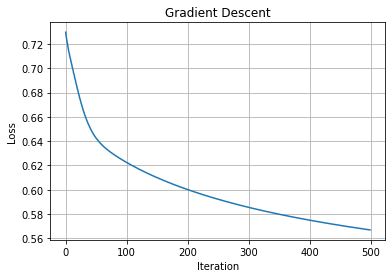

In [ ]:
plt.plot(loss_history)
plt.title("Gradient Descent")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)

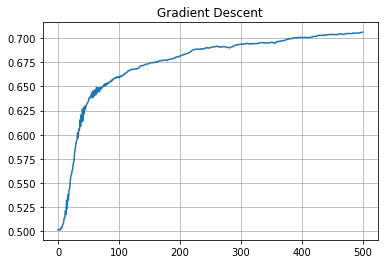

In [ ]:
plt.plot(acc_history_train)
plt.title("Gradient Descent")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta, data_train,y_train, 0.5))
print("validation acc:", accuracy(beta, data_val, y_val, 0.5))
print("validation TPR:", tpr(beta, data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta, data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.7059268
validation acc: 0.711
validation TPR: 0.7208800911903381
validation FPR: 0.32258063554763794


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.76408964


Text(0.5, 1.0, 'TPR against FPR')

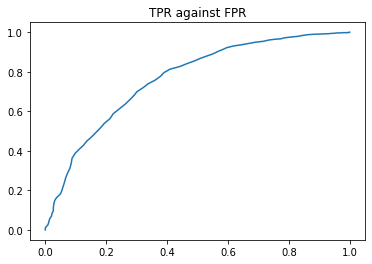

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta, data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**Backtracking**

In [ ]:
beta = onp.copy(beta_init)
n_iter = 500
learning_rate = 100.
loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

acc_history_val = []
tpr_history_val = []
fpr_history_val = []
alpha = 0.5

start = time.time()
for k in range(n_iter):
    # descent direction
    gradient = grad_loss(beta, data_train, y_train)
    descent_direction = -gradient
    
    #adaptive learning rate
    learning_rate = learning_rate * 3
    current_loss = mean_loss(beta, data_train, y_train)
    while mean_loss(beta + learning_rate * descent_direction, data_train, y_train) > current_loss + alpha*learning_rate*np.dot(descent_direction, gradient):
        learning_rate = learning_rate / 2.
    
    #actually do the update
    beta = beta + learning_rate * descent_direction
    
    current_loss = mean_loss(beta, data_train, y_train)
    accuracy_train = accuracy(beta, data_train, y_train,0.5)
    accuracy_val = accuracy(beta, data_val, y_val,0.5)
    tpr_train = tpr(beta, data_train, y_train, 0.5)
    tpr_val = tpr(beta, data_val, y_val, 0.5)
    fpr_train = fpr(beta, data_train, y_train, 0.5)
    fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
    acc_history_train.append(accuracy_train)
    acc_history_val.append(accuracy_val)
    tpr_history_train.append(tpr_train)
    tpr_history_val.append(tpr_val)
    fpr_history_train.append(fpr_train)
    fpr_history_val.append(fpr_val)
    
    if k % 50 == 0:
        print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))
    loss_history.append(current_loss)

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Loss:0.705 	 Accuracy: 47.848% / 60.933%
Loss:0.627 	 Accuracy: 65.534% / 66.500%
Loss:0.608 	 Accuracy: 67.516% / 68.233%
Loss:0.596 	 Accuracy: 68.384% / 69.267%
Loss:0.585 	 Accuracy: 69.441% / 70.467%
Loss:0.577 	 Accuracy: 69.913% / 70.167%
Loss:0.570 	 Accuracy: 70.310% / 70.767%
Loss:0.563 	 Accuracy: 71.121% / 71.767%
Loss:0.558 	 Accuracy: 71.442% / 71.467%
Loss:0.554 	 Accuracy: 71.989% / 72.067%
execution time =  536.202 sec


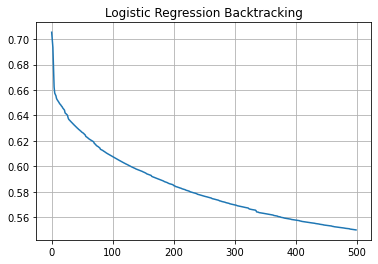

In [ ]:
plt.plot(loss_history)
plt.title("Logistic Regression Backtracking")
plt.grid(True)

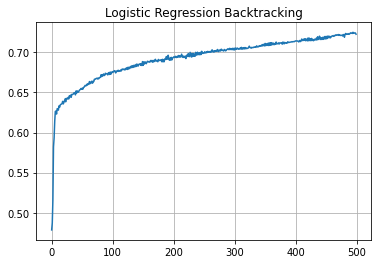

In [ ]:
plt.plot(acc_history_train)
plt.title("Logistic Regression Backtracking")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta, data_train,y_train, 0.5))
print("validation acc:", accuracy(beta, data_val, y_val, 0.5))
print("validation TPR:", tpr(beta, data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta, data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.7227256
validation acc: 0.7183333
validation TPR: 0.728645384311676
validation FPR: 0.3167155385017395


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.7560743


Text(0.5, 1.0, 'TPR against FPR')

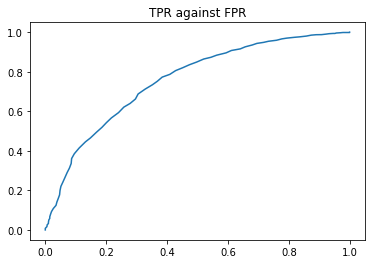

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta, data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**SGD with Momentum**

In [ ]:
beta = onp.copy(beta_init)
prev_beta = onp.copy(beta_init)
learning_rate = 0.001
n_epoch = 600
batch_size = 300
n_balanced_train_data = len(y_train)
m = 0.9 # for momentum

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

acc_history_val = []
tpr_history_val = []
fpr_history_val = []

start = time.time()
for epoch in range(n_epoch):
  for k in range(n_balanced_train_data // batch_size):
    # define curr batch samples
    index = onp.arange(k*batch_size, (k+1)*batch_size) % n_balanced_train_data
    curr_x = data_train[index,]
    curr_y = y_train[index]

    # update
    gradient = grad_loss(beta, curr_x, curr_y)
    temp = beta
    beta = beta - (learning_rate * gradient) + (m * (beta - prev_beta)) # update
    prev_beta = temp

  # record performance
  current_loss = mean_loss(beta, data_train, y_train)
  accuracy_train = accuracy(beta, data_train, y_train,0.5)
  accuracy_val = accuracy(beta, data_val, y_val,0.5)
  tpr_train = tpr(beta, data_train, y_train, 0.5)
  tpr_val = tpr(beta, data_val, y_val, 0.5)
  fpr_train = fpr(beta, data_train, y_train, 0.5)
  fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
  acc_history_train.append(accuracy_train)
  acc_history_val.append(accuracy_val)
  tpr_history_train.append(tpr_train)
  tpr_history_val.append(tpr_val)
  fpr_history_train.append(fpr_train)
  fpr_history_val.append(fpr_val)
  
  if epoch % 60 == 0:
    print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))
  loss_history.append(current_loss)

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

Loss:6.448 	 Accuracy: 50.000% / 22.733%
Loss:1.963 	 Accuracy: 59.872% / 38.233%
Loss:1.662 	 Accuracy: 63.401% / 43.700%
Loss:1.527 	 Accuracy: 65.006% / 46.533%
Loss:1.447 	 Accuracy: 66.063% / 48.233%
Loss:1.391 	 Accuracy: 67.120% / 49.667%
Loss:1.349 	 Accuracy: 67.667% / 50.233%
Loss:1.314 	 Accuracy: 67.875% / 50.467%
Loss:1.285 	 Accuracy: 68.271% / 50.833%
Loss:1.259 	 Accuracy: 68.611% / 51.333%
execution time =  1177.465 sec


Text(0.5, 1.0, 'Stochastic Gradient Descent')

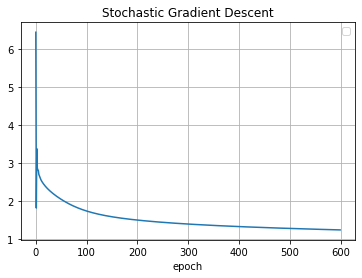

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

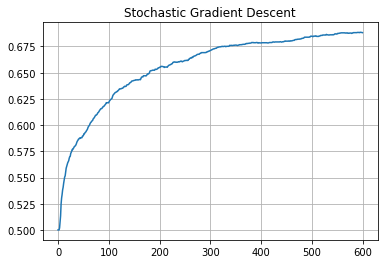

In [ ]:
plt.plot(acc_history_train)
plt.title("Stochastic Gradient Descent")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta, data_train,y_train, 0.5))
print("validation acc:", accuracy(beta, data_val, y_val, 0.5))
print("validation TPR:", tpr(beta, data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta, data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.6881842
validation acc: 0.514
validation TPR: 0.40077653527259827
validation FPR: 0.1011730208992958


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.7498457


Text(0.5, 1.0, 'TPR against FPR')

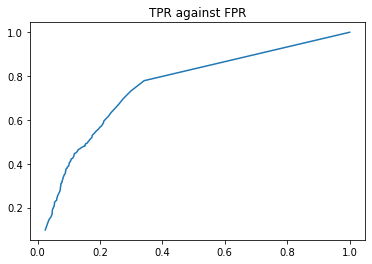

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta, data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**L-BFGS**

In [ ]:
def loss_wrapper(beta):
    """ only one argument """
    return mean_loss(beta, data_train, y_train)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta), dtype='float64')

In [ ]:
beta = onp.copy(beta_init)

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

acc_history_val = []
tpr_history_val = []
fpr_history_val = []

beta_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    current_loss = mean_loss(beta, data_train, y_train)
    accuracy_train = accuracy(beta, data_train, y_train,0.5)
    accuracy_val = accuracy(beta, data_val, y_val,0.5)
    tpr_train = tpr(beta, data_train, y_train, 0.5)
    tpr_val = tpr(beta, data_val, y_val, 0.5)
    fpr_train = fpr(beta, data_train, y_train, 0.5)
    fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
    acc_history_train.append(accuracy_train)
    acc_history_val.append(accuracy_val)
    tpr_history_train.append(tpr_train)
    tpr_history_val.append(tpr_val)
    fpr_history_train.append(fpr_train)
    fpr_history_val.append(fpr_val)

    beta_history.append(beta)

    print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))

    loss_history.append(current_loss)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = beta, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


Loss:0.701 	 Accuracy: 48.018% / 42.067%
Loss:0.692 	 Accuracy: 53.171% / 34.100%
Loss:0.671 	 Accuracy: 58.418% / 41.967%
Loss:0.655 	 Accuracy: 62.269% / 58.433%
Loss:0.650 	 Accuracy: 62.627% / 62.467%
Loss:0.645 	 Accuracy: 63.156% / 65.933%
Loss:0.640 	 Accuracy: 63.326% / 68.600%
Loss:0.630 	 Accuracy: 64.609% / 71.100%
Loss:0.619 	 Accuracy: 64.968% / 70.000%
Loss:0.607 	 Accuracy: 66.289% / 68.233%
Loss:0.597 	 Accuracy: 67.592% / 65.600%
Loss:0.592 	 Accuracy: 68.026% / 64.467%
Loss:0.584 	 Accuracy: 68.535% / 64.233%
Loss:0.582 	 Accuracy: 68.139% / 62.733%
Loss:0.573 	 Accuracy: 69.913% / 69.567%
Loss:0.568 	 Accuracy: 69.743% / 69.500%
Loss:0.563 	 Accuracy: 70.177% / 69.800%
Loss:0.557 	 Accuracy: 70.630% / 72.000%
Loss:0.551 	 Accuracy: 71.555% / 71.167%
Loss:0.548 	 Accuracy: 71.725% / 70.867%
Loss:0.541 	 Accuracy: 72.990% / 71.200%
Loss:0.533 	 Accuracy: 73.330% / 72.867%
Loss:0.529 	 Accuracy: 74.103% / 70.467%
Loss:0.524 	 Accuracy: 74.443% / 71.733%
Loss:0.522 	 Acc

Text(0.5, 1.0, 'L-BFGS-B')

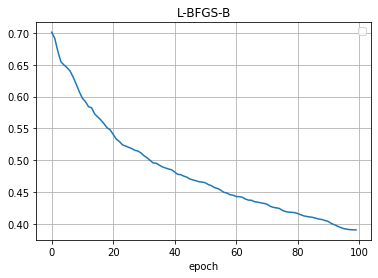

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("L-BFGS-B")

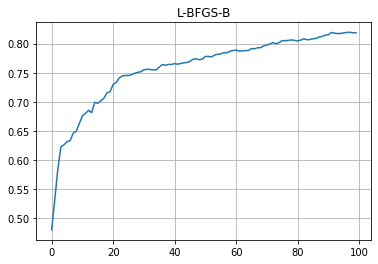

In [ ]:
plt.plot(acc_history_train)
plt.title("L-BFGS-B")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta_history[-1], data_train,y_train, 0.5))
print("validation acc:", accuracy(beta_history[-1], data_val, y_val, 0.5))
print("validation TPR:", tpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.8186108
validation acc: 0.71966666
validation TPR: 0.7195858359336853
validation FPR: 0.2800586521625519


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.7864429


Text(0.5, 1.0, 'TPR against FPR')

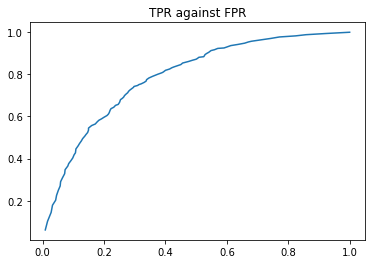

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta_history[-1], data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**L-BFGS with Regularization**

In [ ]:
#L-BFGS -- LASSO (Lambda Selection)
lambda_values = []
lambdas = [0.01,0.05,0.1,0.5] #Grid-Search
val_acc = []
time_taken_list = []
for lambda1 in tqdm(lambdas):
  def loss_wrapper(beta):
      """ only one argument """
      return mean_loss_lasso(beta, data_train, y_train,lambda1)

  grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

  def gradient_wrapper(beta):
      """output is a numpy array"""
      return onp.array(grad_loss_wrapper(beta), dtype='float64')

  beta = onp.copy(beta_init)

  loss_history = []

  acc_history_train = []
  tpr_history_train = []
  fpr_history_train = []

  acc_history_val = []
  tpr_history_val = []
  fpr_history_val = []

  beta_history = []

  def save_traj(beta):
      """ a function that saves a few statistics for later analysis"""
      current_loss = mean_loss_lasso(beta, data_train, y_train,lambda1)
      accuracy_train = accuracy(beta, data_train, y_train,0.5)
      accuracy_val = accuracy(beta, data_val, y_val,0.5)
      tpr_train = tpr(beta, data_train, y_train, 0.5)
      tpr_val = tpr(beta, data_val, y_val, 0.5)
      fpr_train = fpr(beta, data_train, y_train, 0.5)
      fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
      acc_history_train.append(accuracy_train)
      acc_history_val.append(accuracy_val)
      tpr_history_train.append(tpr_train)
      tpr_history_val.append(tpr_val)
      fpr_history_train.append(fpr_train)
      fpr_history_val.append(fpr_val)

      beta_history.append(beta)

      loss_history.append(current_loss)

  #run LBFGS
  start = time.time()
  traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                  x0 = beta, #initial guess
                                  method='L-BFGS-B',  #we want to use L-BFGS
                                  jac=gradient_wrapper, #function that computes the gradient
                                  callback=save_traj, #a function used to save some results for later pltting
                                  options={"maxiter":100})  #maximum number of iteration
  val_acc.append(acc_history_val[-1])

  end = time.time()
  time_taken = end - start
  time_taken_list.append(time_taken)

print("Best Lambda: "+ str(lambdas[val_acc.index(max(val_acc))]))
print("Best Accuracy: "+ str(val_acc[val_acc.index(max(val_acc))]))
print("execution time = {0: .3f} sec".format(time_taken_list[val_acc.index(max(val_acc))]))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



Best Lambda: 0.01
Best Accuracy: 0.6673333
execution time =  92.343 sec


In [ ]:
#L-BFGS -- LASSO (Best Model Analysis)
def loss_wrapper(beta):
    """ only one argument """
    return mean_loss_lasso(beta, data_train, y_train,0.01)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta), dtype='float64')

beta = onp.copy(beta_init)

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

beta_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    current_loss = mean_loss_lasso(beta, data_train, y_train,0.01)
    accuracy_train = accuracy(beta, data_train, y_train,0.5)
    tpr_train = tpr(beta, data_train, y_train, 0.5)
    fpr_train = fpr(beta, data_train, y_train, 0.5)
    
    acc_history_train.append(accuracy_train)
    tpr_history_train.append(tpr_train)
    fpr_history_train.append(fpr_train)

    beta_history.append(beta)

    loss_history.append(current_loss)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = beta, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


execution time =  94.547 sec


Text(0.5, 1.0, 'L-BFGS-B -- LASSO')

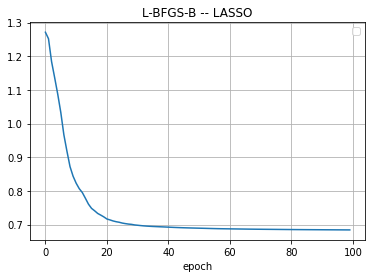

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("L-BFGS-B -- LASSO")

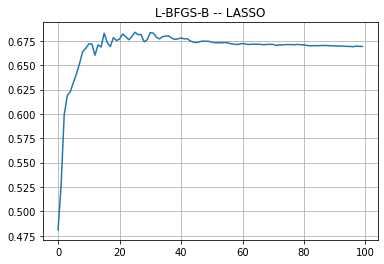

In [ ]:
plt.plot(acc_history_train)
plt.title("L-BFGS-B -- LASSO")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta_history[-1], data_train,y_train, 0.5))
print("validation acc:", accuracy(beta_history[-1], data_val, y_val, 0.5))
print("validation TPR:", tpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.6693092
validation acc: 0.6673333
validation TPR: 0.6712683439254761
validation FPR: 0.3460410535335541


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.7219569


Text(0.5, 1.0, 'TPR against FPR')

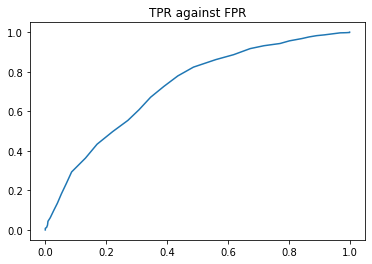

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta_history[-1], data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

In [ ]:
#L-BFGS -- Ridge (Lambda Selection)
lambda_values = []
lambdas = [0.01,0.05,0.1,0.5] #Grid-Search
val_acc = []
time_taken_list = []
for lambda1 in tqdm(lambdas):
  def loss_wrapper(beta):
      """ only one argument """
      return mean_loss_ridge(beta, data_train, y_train,lambda1)

  grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

  def gradient_wrapper(beta):
      """output is a numpy array"""
      return onp.array(grad_loss_wrapper(beta), dtype='float64')

  beta = onp.copy(beta_init)

  loss_history = []

  acc_history_train = []
  tpr_history_train = []
  fpr_history_train = []

  acc_history_val = []
  tpr_history_val = []
  fpr_history_val = []

  beta_history = []

  def save_traj(beta):
      """ a function that saves a few statistics for later analysis"""
      current_loss = mean_loss_ridge(beta, data_train, y_train,lambda1)
      accuracy_train = accuracy(beta, data_train, y_train,0.5)
      accuracy_val = accuracy(beta, data_val, y_val,0.5)
      tpr_train = tpr(beta, data_train, y_train, 0.5)
      tpr_val = tpr(beta, data_val, y_val, 0.5)
      fpr_train = fpr(beta, data_train, y_train, 0.5)
      fpr_val =  fpr(beta, data_val, y_val, 0.5)
    
      acc_history_train.append(accuracy_train)
      acc_history_val.append(accuracy_val)
      tpr_history_train.append(tpr_train)
      tpr_history_val.append(tpr_val)
      fpr_history_train.append(fpr_train)
      fpr_history_val.append(fpr_val)

      beta_history.append(beta)

      loss_history.append(current_loss)

  #run LBFGS
  start = time.time()
  traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                  x0 = beta, #initial guess
                                  method='L-BFGS-B',  #we want to use L-BFGS
                                  jac=gradient_wrapper, #function that computes the gradient
                                  callback=save_traj, #a function used to save some results for later pltting
                                  options={"maxiter":100})  #maximum number of iteration
  val_acc.append(acc_history_val[-1])

  end = time.time()
  time_taken = end - start
  time_taken_list.append(time_taken)

print("Best Lambda: "+ str(lambdas[val_acc.index(max(val_acc))]))
print("Best Accuracy: "+ str(val_acc[val_acc.index(max(val_acc))]))
print("execution time = {0: .3f} sec".format(time_taken_list[val_acc.index(max(val_acc))]))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))



Best Lambda: 0.05
Best Accuracy: 0.7353333
execution time =  136.981 sec


In [ ]:
#L-BFGS -- Ridge (Best Model Analysis)
def loss_wrapper(beta):
    """ only one argument """
    return mean_loss_ridge(beta, data_train, y_train,0.05)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta), dtype='float64')

beta = onp.copy(beta_init)

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

beta_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    current_loss = mean_loss_ridge(beta, data_train, y_train,0.05)
    accuracy_train = accuracy(beta, data_train, y_train,0.5)
    tpr_train = tpr(beta, data_train, y_train, 0.5)
    fpr_train = fpr(beta, data_train, y_train, 0.5)
    
    acc_history_train.append(accuracy_train)
    tpr_history_train.append(tpr_train)
    fpr_history_train.append(fpr_train)

    beta_history.append(beta)

    loss_history.append(current_loss)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = beta, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


execution time =  120.013 sec


Text(0.5, 1.0, 'L-BFGS-B -- Ridge')

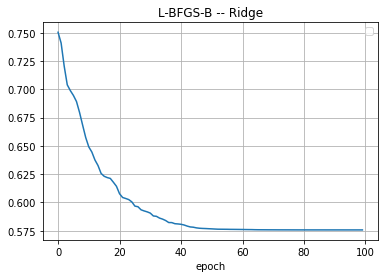

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("L-BFGS-B -- Ridge")

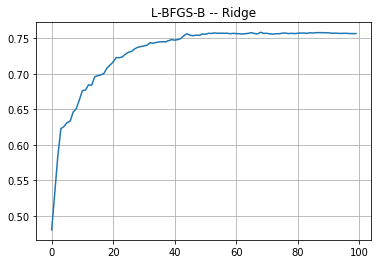

In [ ]:
plt.plot(acc_history_train)
plt.title("L-BFGS-B -- Ridge")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta_history[-1], data_train,y_train, 0.5))
print("validation acc:", accuracy(beta_history[-1], data_val, y_val, 0.5))
print("validation TPR:", tpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 1 better
print("validation FPR:", fpr(beta_history[-1], data_val, y_val, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.75651187
validation acc: 0.7353333
validation TPR: 0.7476272583007812
validation FPR: 0.30645161867141724


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.7885442


Text(0.5, 1.0, 'TPR against FPR')

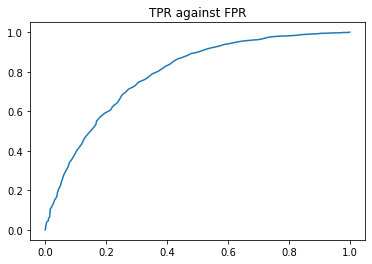

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta_history[-1], data_val, y_val)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**Best Model (L-BFGS -- Ridge -- Lambda = 0.05)**



In [ ]:
#Fitting Full Training on Test 
def loss_wrapper(beta):
    """ only one argument """
    return mean_loss_ridge(beta, data_full_train, y_full_train,0.05)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta), dtype='float64')

beta = onp.copy(beta_init)

loss_history = []

acc_history_train = []
tpr_history_train = []
fpr_history_train = []

beta_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    current_loss = mean_loss_ridge(beta, data_full_train, y_full_train,0.05)
    accuracy_train = accuracy(beta, data_full_train, y_full_train,0.5)
    tpr_train = tpr(beta, data_full_train, y_full_train, 0.5)
    fpr_train = fpr(beta, data_full_train, y_full_train, 0.5)
    
    acc_history_train.append(accuracy_train)
    tpr_history_train.append(tpr_train)
    fpr_history_train.append(fpr_train)

    beta_history.append(beta)

    loss_history.append(current_loss)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = beta, #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

end = time.time()
time_taken = end - start
print("execution time = {0: .3f} sec".format(time_taken))

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


execution time =  202.991 sec


Text(0.5, 1.0, 'L-BFGS-B Ridge')

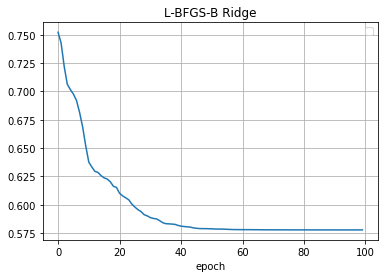

In [ ]:
plt.plot(loss_history)
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("L-BFGS-B Ridge")

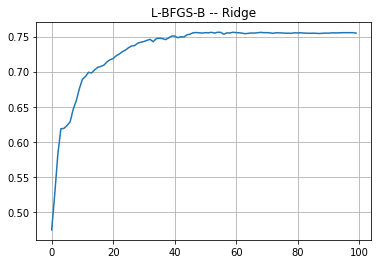

In [ ]:
plt.plot(acc_history_train)
plt.title("L-BFGS-B -- Ridge")
plt.grid(True)

In [ ]:
print("train acc:", accuracy(beta_history[-1], data_full_train,y_full_train, 0.5))
print("test acc:", accuracy(beta_history[-1], data_test, y_test, 0.5))
print("test TPR:", tpr(beta_history[-1], data_test, y_test, 0.5)) # closer to 1 better
print("test FPR:", fpr(beta_history[-1], data_test, y_test, 0.5)) # closer to 0 better

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


train acc: 0.7548784
test acc: 0.744
test TPR: 0.7470093965530396
test FPR: 0.2670401632785797


/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:4670: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


area: 0.81186956


Text(0.5, 1.0, 'TPR against FPR')

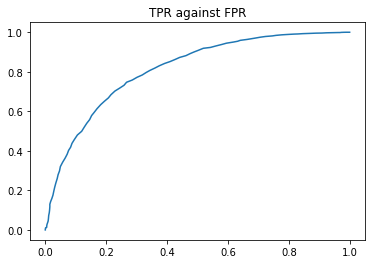

In [ ]:
# roc curve with auc
tpr_fpr = auc(beta_history[-1], data_test, y_test)[1:]
plt.plot(tpr_fpr[1], tpr_fpr[0])
plt.title("TPR against FPR")

**Visualisation**

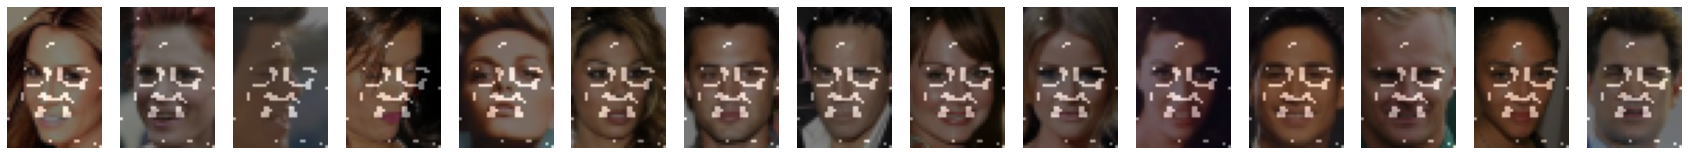

In [ ]:
plt.figure(figsize=(30,20))
for k in range(15):
    plt.subplot(1,15,k+1)
    plt.imshow(train_img_array[k], cmap="gray")
    plt.imshow(onp.mean(beta_history[-1].reshape((51,34,3)),axis=2)>0.02,alpha=0.5,cmap="gray")
    plt.axis("off")

(-0.5, 33.5, 50.5, -0.5)

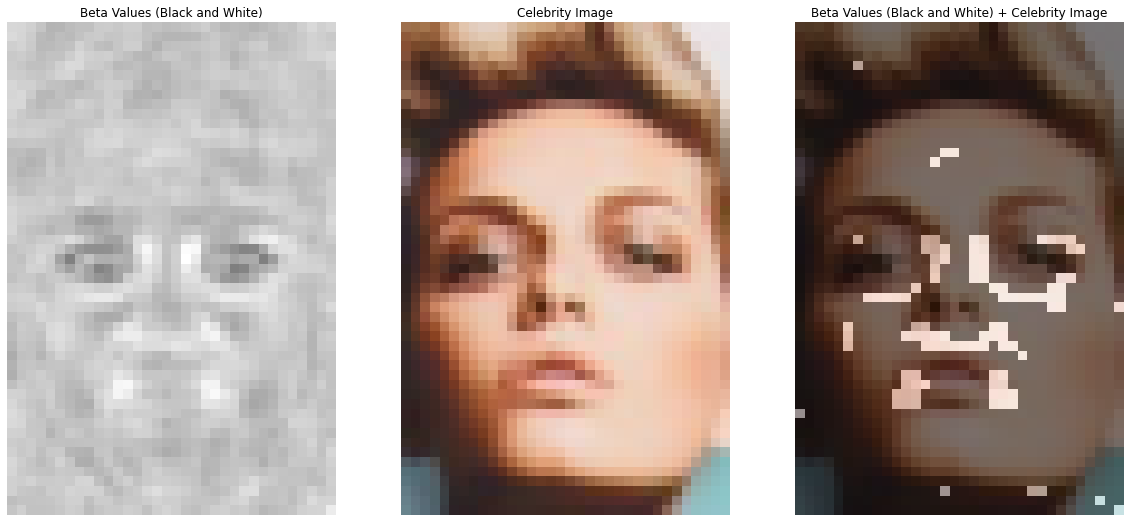

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(onp.mean(beta_history[-1].reshape((51,34,3)),axis=2),alpha=0.5,cmap="gray")
plt.title("Beta Values (Black and White)")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(train_img_array[4], cmap="gray")
plt.title("Celebrity Image")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(train_img_array[4], cmap="gray")
plt.imshow(onp.mean(beta_history[-1].reshape((51,34,3)),axis=2)>0.02,alpha=0.5,cmap="gray")
plt.title("Beta Values (Black and White) + Celebrity Image")
plt.axis("off")

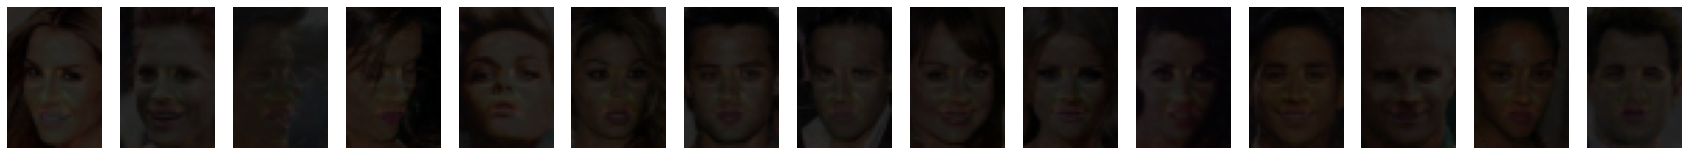

In [ ]:
plt.figure(figsize=(30,20))
for k in range(15):
    plt.subplot(1,15,k+1)
    plt.imshow(train_img_array[k], cmap="gray")
    plt.imshow(beta_history[-1].reshape((51,34,3)),alpha=0.85,cmap="gray")
    plt.axis("off")

(-0.5, 33.5, 50.5, -0.5)

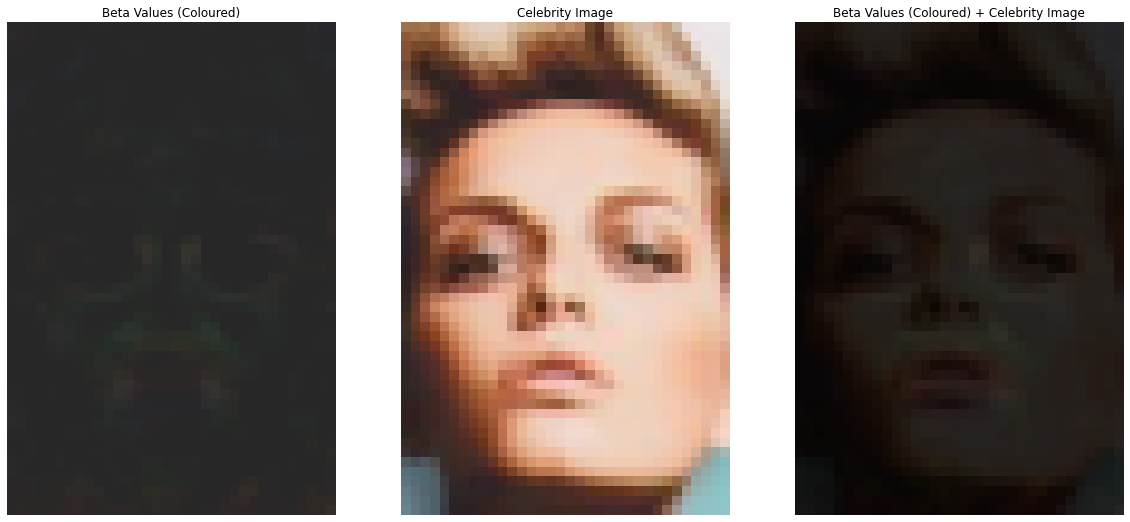

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(beta_history[-1].reshape((51,34,3)),alpha=0.85,cmap="gray")
plt.title("Beta Values (Coloured)")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(train_img_array[4], cmap="gray")
plt.title("Celebrity Image")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(train_img_array[4], cmap="gray")
plt.imshow(beta_history[-1].reshape((51,34,3)),alpha=0.85,cmap="gray")
plt.title("Beta Values (Coloured) + Celebrity Image")
plt.axis("off")